# Fit missing-mass squared distributions

In [1]:
# on ifarm, use Python 3.6.8
import array

import numpy as np
import ROOT
from pathvalidate import sanitize_filename, sanitize_filepath
from uncertainties import ufloat
from uncertainties.umath import *

import fitFunction  # defines fit function: double Gaussian on top of a 2nd-order polynomial
import makePlots    # defines helper functions to generate histograms from data trees

makePlots.setupPlotStyle()

Welcome to JupyROOT 6.24/04


## Define parameters and load input data

In [2]:
# selection         = "paul"
selection         = "justin"
# particle          = "Pi-"
# particle          = "Pi+"
particle          = "Proton"
# channel           = "2pi"
channel           = "4pi"
# dataset           = "30370_acc_Pval"
dataset           = "bggen_2017_01-ver03"
# if selection == "paul":
#   inFileName = f"../pmatt/trackeff_{particle}_{channel}{f'.{dataset}' if dataset != '' else ''}.root"
# elif selection == "justin":
#   inFileName = f"../ReactionEfficiency/pippippimpimpmiss_bggen_2017_01-ver03.root"
# else:
#   raise ValueError(f"Unknown selection '{selection}'")
treeFileName      = "../ReactionEfficiency/pippippimpimpmiss_flatTree_bggen_2017_01-ver03.root"
treeName          = "pippippimpimpmiss"

trackFoundCondition  = makePlots.UNUSED_TRACK_FOUND_CONDITION

additionalFilter  = None
pdfFileNameSuffix = ""
# additionalFilter  = '(ThrownTopology.GetString() == "2#pi^{#plus}2#pi^{#minus}p")'
# pdfFileNameSuffix = "__sig"
# additionalFilter  = '(ThrownTopology.GetString() == "2#gamma2#pi^{#plus}2#pi^{#minus}p[#pi^{0}]")'
# pdfFileNameSuffix = "__2#gamma2#pi^{#plus}2#pi^{#minus}p[#pi^{0}]"
# additionalFilter  = '(ThrownTopology.GetString() != "2#pi^{#plus}2#pi^{#minus}p")'
# pdfFileNameSuffix = "__bkg"
# additionalFilter  = "(NmbUnusedShowers == 0)"
# pdfFileNameSuffix = "__noUnusedShowers"

mm2HistDef        = {
  "variables"      : ("MissingMassSquared_Measured",),
  "axisTitles"     : "(#it{m}^{miss}_{measured})^{2} (GeV/c^{2})^{2}",
  "binning"        : (250, -0.5, 4.5),
  "weightVariable" : "AccidWeightFactor"
}
mm2FitRange       = (-0.5, 4)  # [(GeV/c)^2]

# define equidistant 1D kinematic binning
kinematicBinning  = {  # beam energy
  "variable" : "BeamEnergy", "label" : "Beam Energy", "unit" : "GeV",
  "nmbBins" : 9, "range" : (3.0, 12.0)
}
# kinematicBinning  = {  # momentum of missing proton
#   "variable" : "MissingProtonP", "label" : "#it{p}^{miss}_{kin. fit}", "unit" : "GeV/c",
#   "nmbBins" : 10, "range" : (0, 3.5)
# }
# kinematicBinning  = {  # polar angle of missing proton
#   "variable" : "MissingProtonTheta", "label" : "#it{#theta}^{miss}_{kin. fit}", "unit" : "deg",
#   "nmbBins" : 13, "range" : (0, 65)
# }
# kinematicBinning  = {  # azimuthal angle of missing proton
#   "variable" : "MissingProtonPhi", "label" : "#it{#phi}^{miss}_{kin. fit}", "unit" : "deg",
#   "nmbBins" : 10, "range" : (-180, +180)
# }
markerSize        = 0.75

ROOT.EnableImplicitMT()   # activate implicit multi-threading for RDataFrame
inputData = ROOT.RDataFrame(treeName, treeFileName).Define("TrackFound", trackFoundCondition)
ROOT.DisableImplicitMT()  # NOTE! enabling multithreading via ROOT.EnableImplicitMT() sends Minuit into an infinite loop (on ROOT 6.24/04 (ifarm) and 6.26/10)

## Tracking efficiency from overall missing-mass squared distributions

### Get overall missing-mass squared distributions by projecting the 2D histograms and adjust binning

Info in <TCanvas::Print>: pdf file ./justin_Proton_4pi_bggen_2017_01-ver03_mm2_Total.pdf has been created
Info in <TCanvas::Print>: pdf file ./justin_Proton_4pi_bggen_2017_01-ver03_mm2_Found.pdf has been created
Info in <TCanvas::Print>: pdf file ./justin_Proton_4pi_bggen_2017_01-ver03_mm2_Missing.pdf has been created


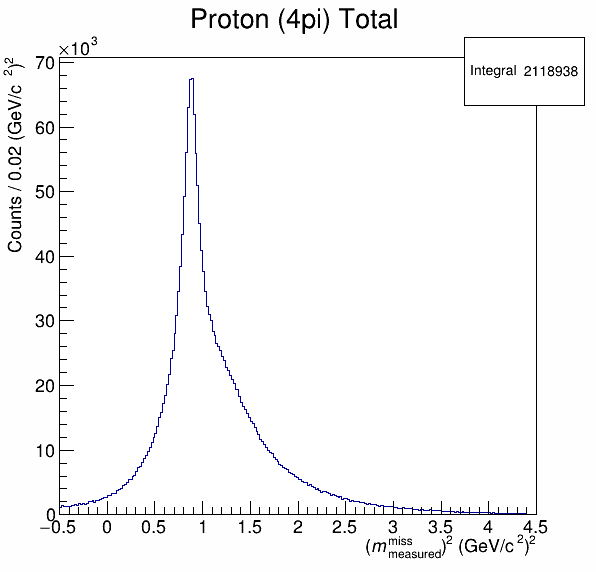

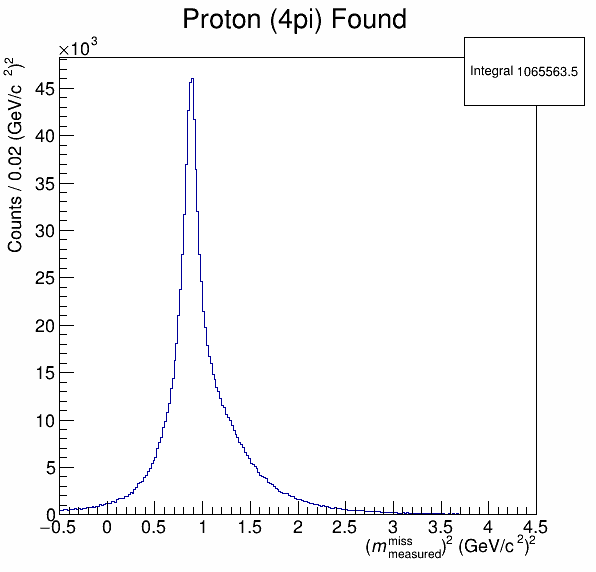

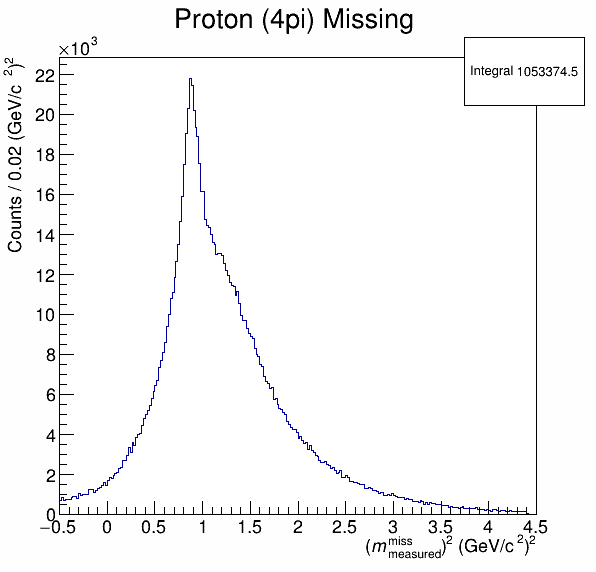

In [3]:
ROOT.EnableImplicitMT()
MM2Hists = {}
for case, caseFilter in makePlots.FILTER_CASES.items():
  caseData = inputData.Filter(caseFilter)
  MM2Hists[case] = makePlots.getHistND(caseData, **mm2HistDef, filterExpression = additionalFilter,
    histNameSuffix = case, histTitle = f"{particle} ({channel}) {case}")
# MM2Hists = {case : inFile.Get("MissingMassSquared/MissingMassSquared" + ("" if case == "Total" else "_" + case)) for case in ["Total", "Found", "Missing"]}
# MM2Hists = {case : inFile.Get("MissingMassSquared/MissingMassSquared" + ("" if case == "Total" else "_" + case) + "__2#pi^{#plus}2#pi^{#minus}p") for case in ["Total", "Found", "Missing"]}
# MM2Hists = {case : inFile.Get("MissingMassSquared/MissingMassSquared" + ("" if case == "Total" else "_" + case) + "__2#gamma2#pi^{#plus}2#pi^{#minus}p[#pi^{0}]") for case in ["Total", "Found", "Missing"]}
canvs = []
for case, MM2Hist in MM2Hists.items():
  canv = ROOT.TCanvas(sanitize_filename(f"{selection}_{particle}_{channel}_{dataset}_mm2_{case}{pdfFileNameSuffix}"), "")
  MM2Hist.Draw("HIST")
  MM2Hist.SetYTitle(f"Counts / {MM2Hist.GetBinWidth(1)} (GeV/c^{{2}})^{{2}}")
  canv.Draw()
  canv.SaveAs(".pdf")
  canvs.append(canv)
ROOT.DisableImplicitMT()

### Fit missing-mass squared distributions for the 3 cases

In [4]:
fitResults = {case : fitFunction.fitDistribution(MM2Hist, particle, mm2FitRange, forceCommonGaussianMean = False) for (case, MM2Hist) in MM2Hists.items()}

Fitting histogram 'MissingMassSquared_Measured_Total', 'Proton (4pi) Total'.
    reduced chi^2 = 82.6973377818202; P-value = 0.0
Fitting histogram 'MissingMassSquared_Measured_Found', 'Proton (4pi) Found'.
    reduced chi^2 = 54.82329419577948; P-value = 0.0
Fitting histogram 'MissingMassSquared_Measured_Missing', 'Proton (4pi) Missing'.
    reduced chi^2 = 22.179867006405082; P-value = 0.0
 NEW MINIMUM FOUND.  GO BACK TO MINIMIZATION STEP.
                                                  V
                                                  V
                                                  V
                                               VVVVVVV
                                                VVVVV
                                                 VVV
                                                  V

 FCN=16821.4 FROM MINOS     STATUS=SUCCESSFUL     68 CALLS        3143 TOTAL
                     EDM=1.65876e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER            

In [5]:
def fitStatusString(fitResult):
  return (
    f"minimizer status = {fitResult.Status()}, "
    f"fit result is valid = {fitResult.IsValid()}, "
    f"covariance matrix status = {fitFunction.COV_MATRIX_STATUS_CODE[fitResult.CovMatrixStatus()][1]}"
  )

Show fit result

Total: minimizer status = 4000, fit result is valid = True, covariance matrix status = full accurate matrix
Found: minimizer status = 4000, fit result is valid = True, covariance matrix status = full accurate matrix
Missing: minimizer status = 4000, fit result is valid = True, covariance matrix status = full accurate matrix


Info in <TCanvas::Print>: pdf file ./justin_Proton_4pi_bggen_2017_01-ver03_mm2_fit_Total.pdf has been created
Info in <TCanvas::Print>: pdf file ./justin_Proton_4pi_bggen_2017_01-ver03_mm2_fit_Found.pdf has been created
Info in <TCanvas::Print>: pdf file ./justin_Proton_4pi_bggen_2017_01-ver03_mm2_fit_Missing.pdf has been created


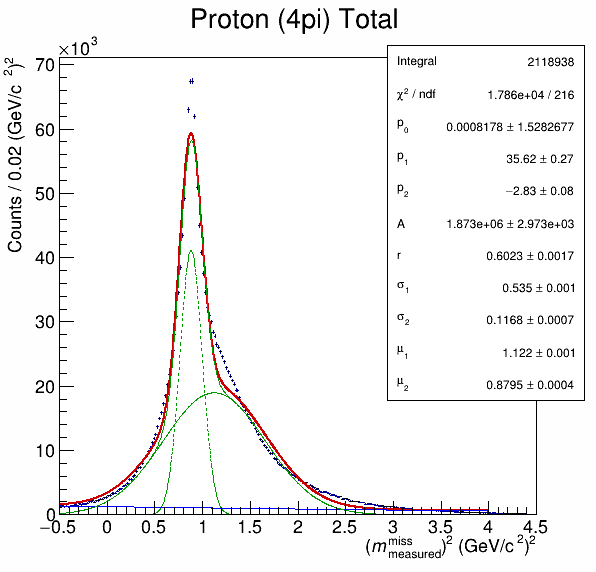

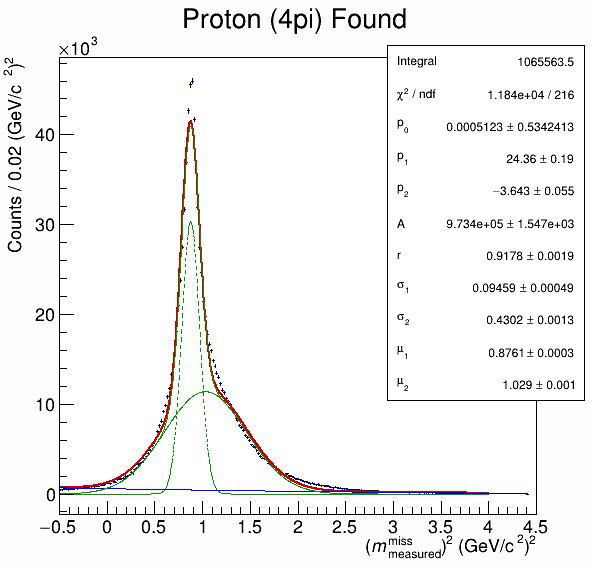

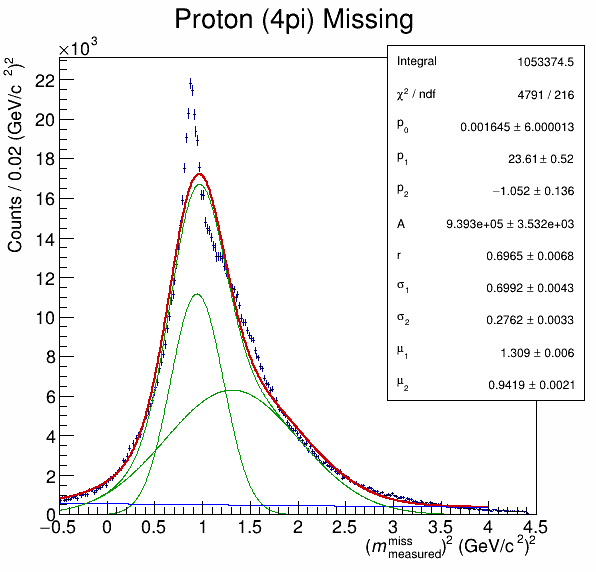

In [6]:
canvsOverall = {}
for case, MM2Hist in MM2Hists.items():
  canvsOverall[case] = ROOT.TCanvas(sanitize_filename(f"{selection}_{particle}_{channel}_{dataset}_mm2_fit_{case}{pdfFileNameSuffix}"), "")
  MM2Hist.Draw()
  canvsOverall[case].Update()  # needed otherwise TPaveStats object is not created
  stats = MM2Hist.FindObject("stats")
  stats.SetX1NDC(0.65)
  stats.SetX2NDC(0.98)
  stats.SetY1NDC(0.3)
  stats.SetY2NDC(0.92)
  canvsOverall[case].Draw()
  canvsOverall[case].SaveAs(".pdf")
for case, fitResult in fitResults.items():
  print(f"{case}: {fitStatusString(fitResult)}")

### Get overall signal yields and calculate average efficiency

In [7]:
def getFitParameter(fitResult, parName):
  parIndex = fitResult.Index(parName)
  return ufloat(fitResult.Parameter(parIndex), fitResult.ParError(parIndex))

In [8]:
def getSignalYield(fitResult):
  return getFitParameter(fitResult, "A")

In [9]:
def calculateEfficiency(fitResults):  # dictionary with TFitResults for "Total", "Found", and "Missing"
  signalYields = {case : getSignalYield(fitResult) for (case, fitResult) in fitResults.items()}
  return signalYields["Found"] / (signalYields["Found"] + signalYields["Missing"])

In [10]:
signalYields = {case : getSignalYield(fitResult) for (case, fitResult) in fitResults.items()}
overallEff = calculateEfficiency(fitResults)
#TODO one could perform a combined fit of all 3 histograms enforcing Found + Missing == Total
print(signalYields, f"mismatch = {100 * (signalYields['Total'] - signalYields['Found'] - signalYields['Missing']) / signalYields['Total']}%")
print(f"Overall efficiency = {100 * overallEff}%")
# {'Total': 1873153.5428730857+/-2973.1052778913872, 'Found': 973390.6673264182+/-1547.0396174425841, 'Missing': 939329.6803516215+/-3532.4453758962336} mismatch = -2.11+/-0.26%
# Overall efficiency = 50.89+/-0.10%

{'Total': 1873153.5178034364+/-2973.104685757193, 'Found': 973390.6658839565+/-1547.0396370581584, 'Missing': 939327.6170518497+/-3532.3849003169453} mismatch = -2.11+/-0.26%
Overall efficiency = 50.89+/-0.10%


## Tracking efficiencies as a function of the given kinematic variable from missing-mass squared distributions

### Fit missing-mass squared distributions in bins of the given kinematic variable

In [11]:
# generates histograms from tree and returns dictionary of dictionaries {case : {kinematic bin : histogram, ...}, ...}
#TODO complete interface
def getHistsKinematicBins1D(
  kinematicBinning,  # dict with binning definition
  minCounts = 500   # minimum number of counts required in kinematic bin
):
  ROOT.EnableImplicitMT()
  MM2HistsKinBins = {}
  kinBinVariable = kinematicBinning["variable"]
  nmbKinBins     = kinematicBinning["nmbBins"]
  kinBinRange    = kinematicBinning["range"]
  kinBinWidth    = (kinBinRange[1] - kinBinRange[0]) / float(nmbKinBins)
  for case, caseFilter in makePlots.FILTER_CASES.items():
    caseData = inputData.Filter(caseFilter)
    MM2HistsKinBins[case] = {}
    for kinBinIndex in range(nmbKinBins):
      kinBinMin = kinBinRange[0] + kinBinIndex * kinBinWidth
      kinBinMax = kinBinMin + kinBinWidth
      kinBinFilter = f"(({kinBinMin} < {kinBinVariable}) and ({kinBinVariable} < {kinBinMax}))"
      kinBinData = caseData.Filter(kinBinFilter)
      MM2Hist = makePlots.getHistND(kinBinData, **mm2HistDef, filterExpression = additionalFilter,
        histNameSuffix = f"{kinBinVariable}_{kinBinMin}_{kinBinMax}_{case}",
        histTitle = f"{particle} ({channel}) {case}, {kinBinMin} < {kinBinVariable} < {kinBinMax} {kinematicBinning['unit']}")
      MM2Hist.Draw()
      MM2Hist.SetYTitle(f"Counts / {MM2Hist.GetBinWidth(1)} (GeV/c^{{2}})^{{2}}")
      counts = MM2Hist.Integral(1, MM2Hist.GetNbinsX())
      if counts >= minCounts:
        MM2HistsKinBins[case][(kinBinVariable, kinBinMin, kinBinMax)] = MM2Hist
      else:
        print(f"Warning: {counts} counts in kinematic bin {kinBinMin} < {kinBinVariable} < {kinBinMax} {kinematicBinning['unit']} are below the required minimum of {minCounts}. Skipping bin.")
  ROOT.DisableImplicitMT()
  return MM2HistsKinBins

In [12]:
MM2HistsKinBins = getHistsKinematicBins1D(kinematicBinning)

In [13]:
def fitMissingMassSquaredKinematicBins1D(
  MM2HistsKinBins,  # dictionary of dictionaries {case : {kinematic bin : histogram, ...}, ...}
  **kwargs
):
  fitResults = {}
  for case, MM2Hists in MM2HistsKinBins.items():
    fitResults[case] = {}
    for kinBin, MM2Hist in MM2Hists.items():
      # fit distribution
      print(f"Fitting case {case} for kinematic bin {kinBin[1]} < {kinBin[0]} < {kinBin[2]} {kinematicBinning['unit']}")
      fitResults[case][kinBin] = fitFunction.fitDistribution(MM2Hist, **kwargs)

  return fitResults

In [14]:
fitResultsKinBins = fitMissingMassSquaredKinematicBins1D(MM2HistsKinBins, particle = particle, fitRange = mm2FitRange, forceCommonGaussianMean = True)

Fitting case Total for kinematic bin 3.0 < BeamEnergy < 4.0 GeV
Fitting histogram 'MissingMassSquared_Measured_BeamEnergy_3.0_4.0_Total', 'Proton (4pi) Total, 3.0 < BeamEnergy < 4.0 GeV'.
    reduced chi^2 = 5.012590488603937; P-value = 2.3230360164727144e-92
Fitting case Total for kinematic bin 4.0 < BeamEnergy < 5.0 GeV
Fitting histogram 'MissingMassSquared_Measured_BeamEnergy_4.0_5.0_Total', 'Proton (4pi) Total, 4.0 < BeamEnergy < 5.0 GeV'.
    reduced chi^2 = 3.6675449830190847; P-value = 6.007041344559239e-65
Fitting case Total for kinematic bin 5.0 < BeamEnergy < 6.0 GeV
Fitting histogram 'MissingMassSquared_Measured_BeamEnergy_5.0_6.0_Total', 'Proton (4pi) Total, 5.0 < BeamEnergy < 6.0 GeV'.
    reduced chi^2 = 3.342665011259318; P-value = 4.855216106233599e-56
Fitting case Total for kinematic bin 6.0 < BeamEnergy < 7.0 GeV
Fitting histogram 'MissingMassSquared_Measured_BeamEnergy_6.0_7.0_Total', 'Proton (4pi) Total, 6.0 < BeamEnergy < 7.0 GeV'.
    reduced chi^2 = 4.97833509580

### Check whether fits converged

In [15]:
for case, fitResults in fitResultsKinBins.items():
  for kinBin, fitResult in fitResults.items():
    print(f"case {case}, kinematic bin {kinBin[1]} < {kinBin[0]} < {kinBin[2]} {kinematicBinning['unit']}: {fitStatusString(fitResult)}")

case Total, kinematic bin 3.0 < BeamEnergy < 4.0 GeV: minimizer status = 4000, fit result is valid = True, covariance matrix status = full accurate matrix
case Total, kinematic bin 4.0 < BeamEnergy < 5.0 GeV: minimizer status = 4000, fit result is valid = True, covariance matrix status = full accurate matrix
case Total, kinematic bin 5.0 < BeamEnergy < 6.0 GeV: minimizer status = 4000, fit result is valid = True, covariance matrix status = full accurate matrix
case Total, kinematic bin 6.0 < BeamEnergy < 7.0 GeV: minimizer status = 4000, fit result is valid = True, covariance matrix status = full accurate matrix
case Total, kinematic bin 7.0 < BeamEnergy < 8.0 GeV: minimizer status = 4000, fit result is valid = True, covariance matrix status = full accurate matrix
case Total, kinematic bin 8.0 < BeamEnergy < 9.0 GeV: minimizer status = 4000, fit result is valid = True, covariance matrix status = full accurate matrix
case Total, kinematic bin 9.0 < BeamEnergy < 10.0 GeV: minimizer statu

### Show fits

Info in <TCanvas::Print>: pdf file ./justin_Proton_4pi_bggen_2017_01-ver03_mm2_BeamEnergy_3.0_4.0_fit_Total.pdf has been created
Info in <TCanvas::Print>: pdf file ./justin_Proton_4pi_bggen_2017_01-ver03_mm2_BeamEnergy_4.0_5.0_fit_Total.pdf has been created
Info in <TCanvas::Print>: pdf file ./justin_Proton_4pi_bggen_2017_01-ver03_mm2_BeamEnergy_5.0_6.0_fit_Total.pdf has been created
Info in <TCanvas::Print>: pdf file ./justin_Proton_4pi_bggen_2017_01-ver03_mm2_BeamEnergy_6.0_7.0_fit_Total.pdf has been created
Info in <TCanvas::Print>: pdf file ./justin_Proton_4pi_bggen_2017_01-ver03_mm2_BeamEnergy_7.0_8.0_fit_Total.pdf has been created
Info in <TCanvas::Print>: pdf file ./justin_Proton_4pi_bggen_2017_01-ver03_mm2_BeamEnergy_8.0_9.0_fit_Total.pdf has been created
Info in <TCanvas::Print>: pdf file ./justin_Proton_4pi_bggen_2017_01-ver03_mm2_BeamEnergy_9.0_10.0_fit_Total.pdf has been created
Info in <TCanvas::Print>: pdf file ./justin_Proton_4pi_bggen_2017_01-ver03_mm2_BeamEnergy_10.0_1

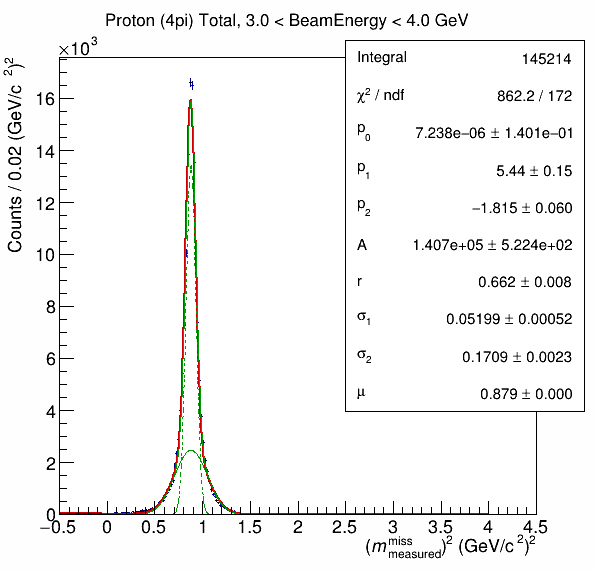

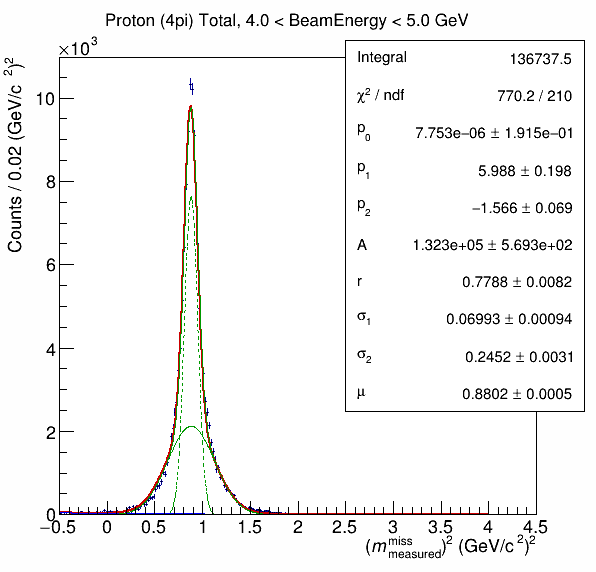

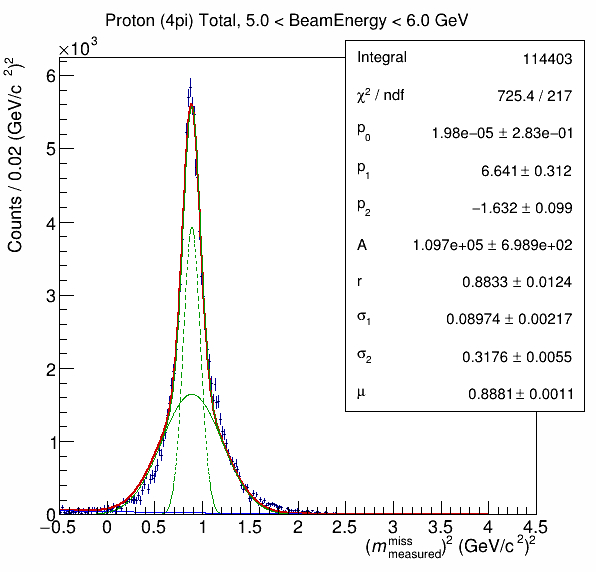

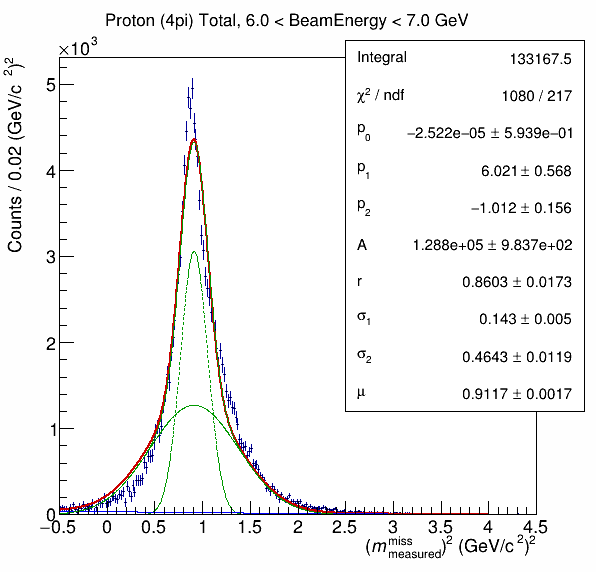

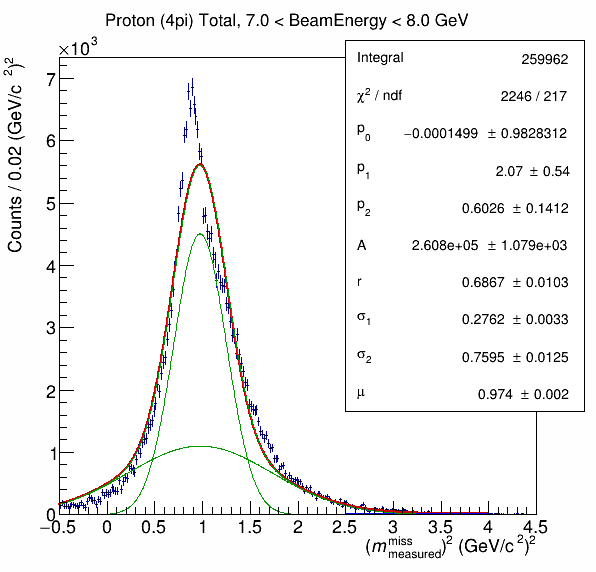

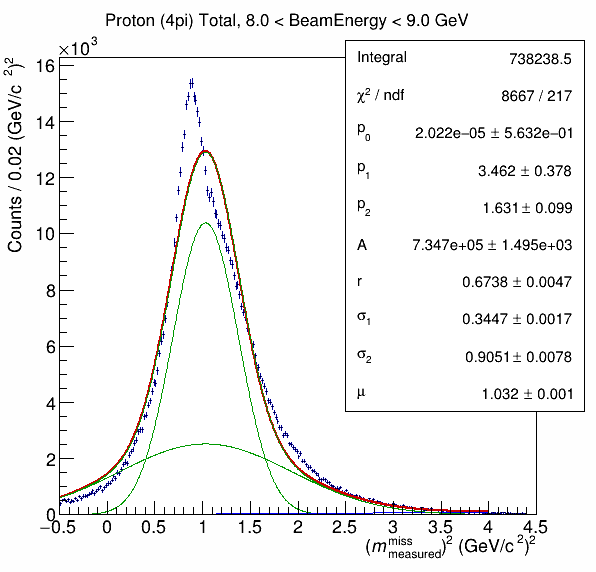

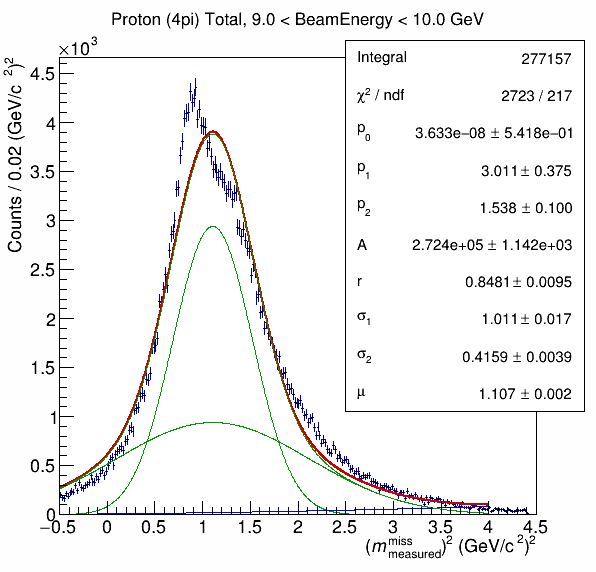

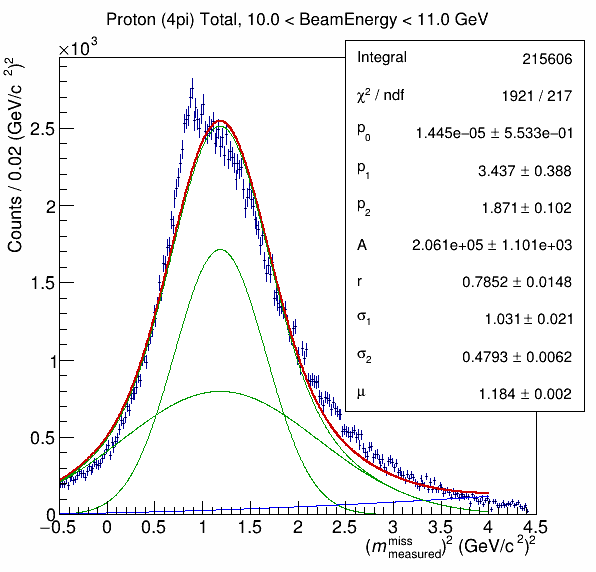

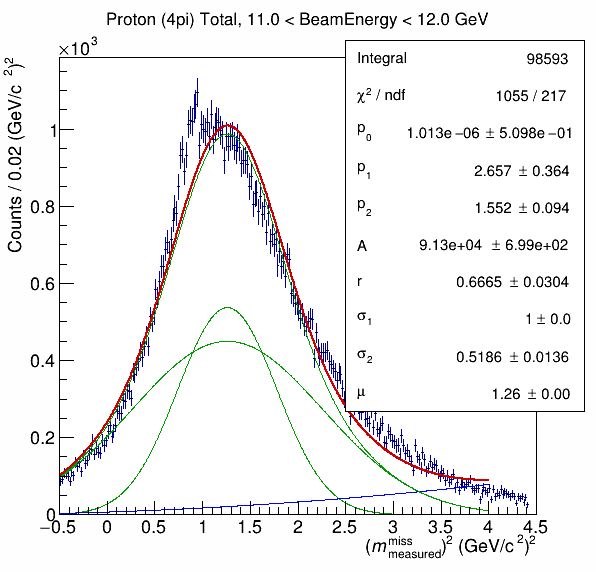

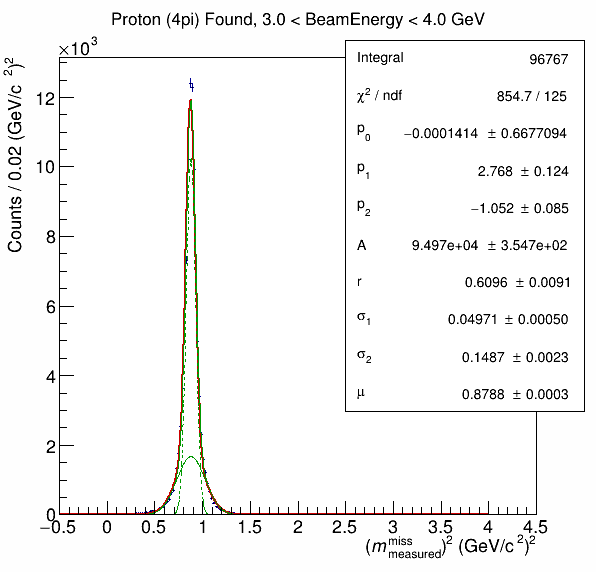

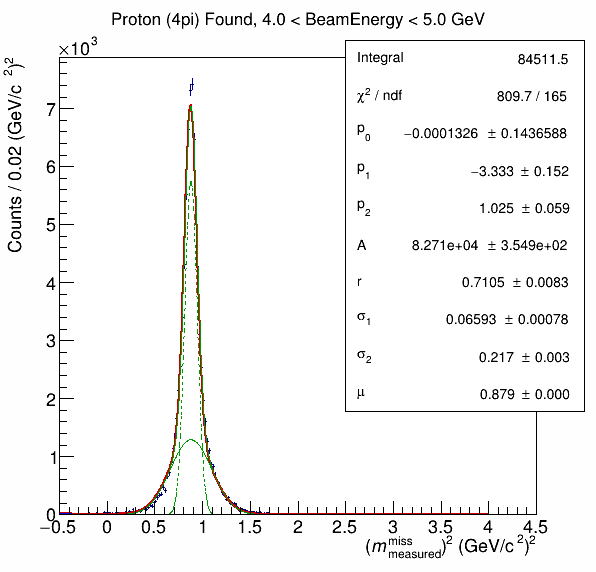

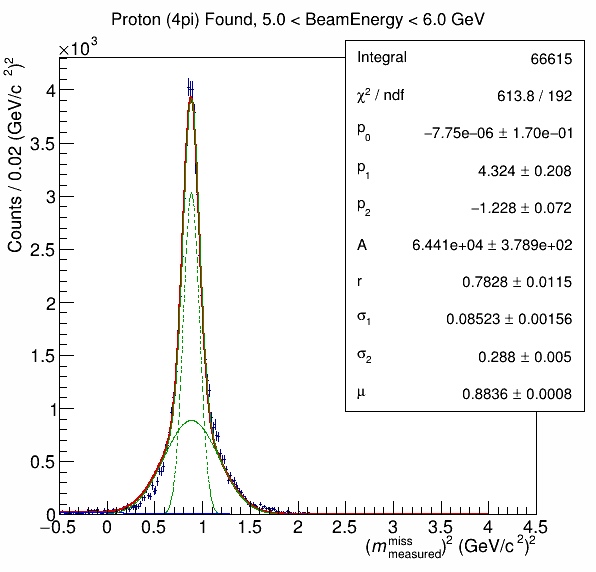

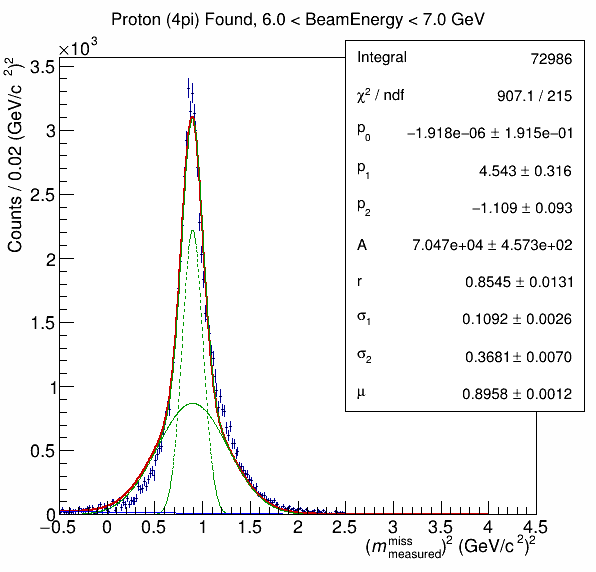

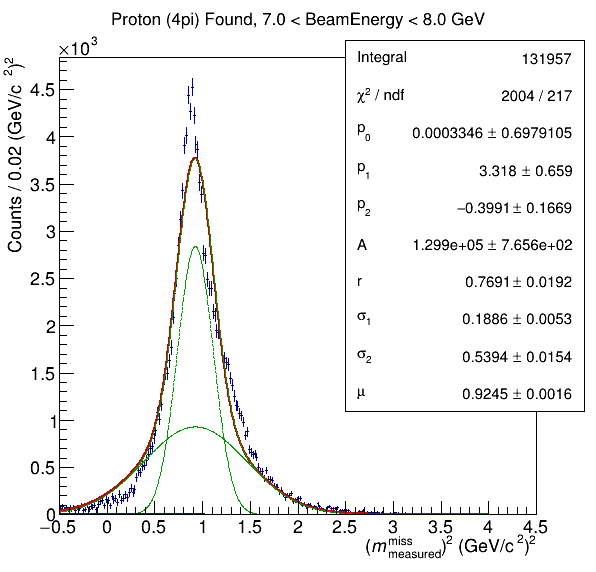

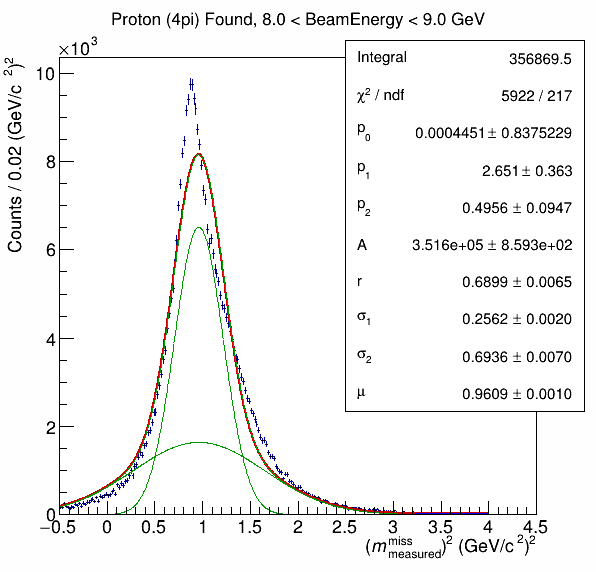

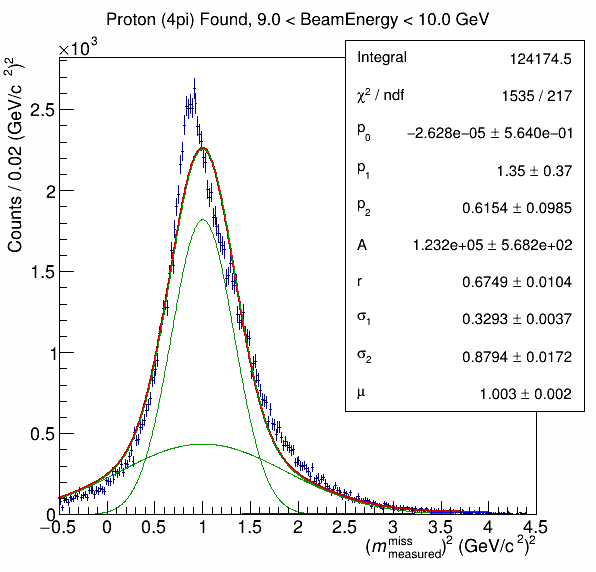

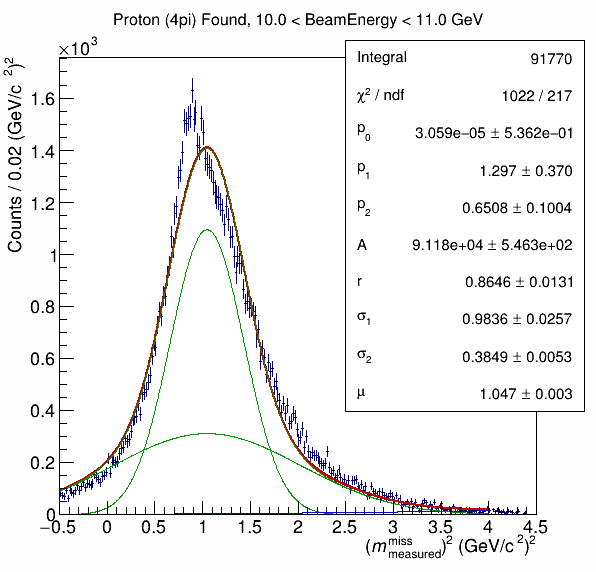

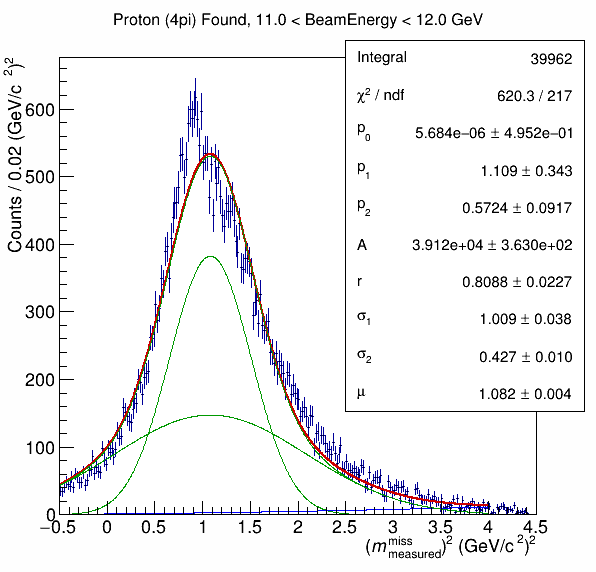

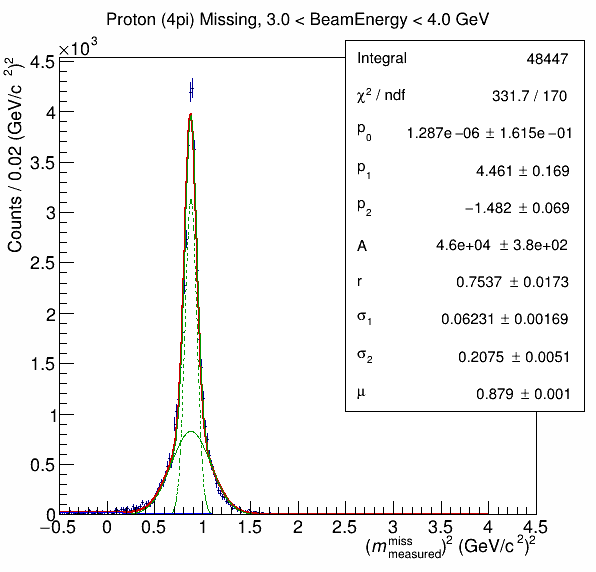

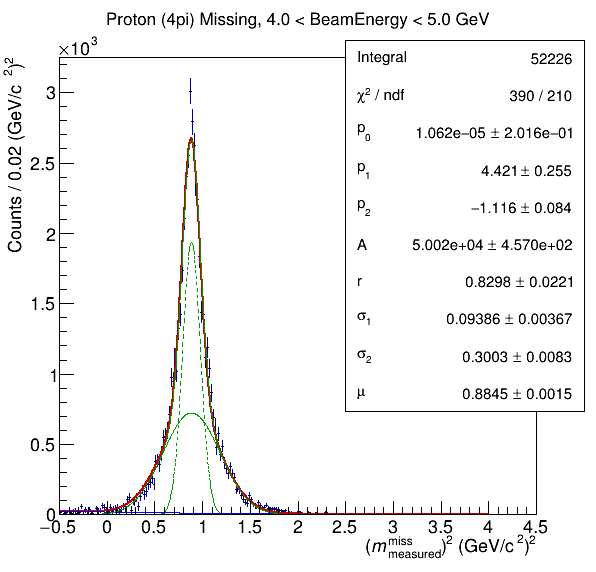

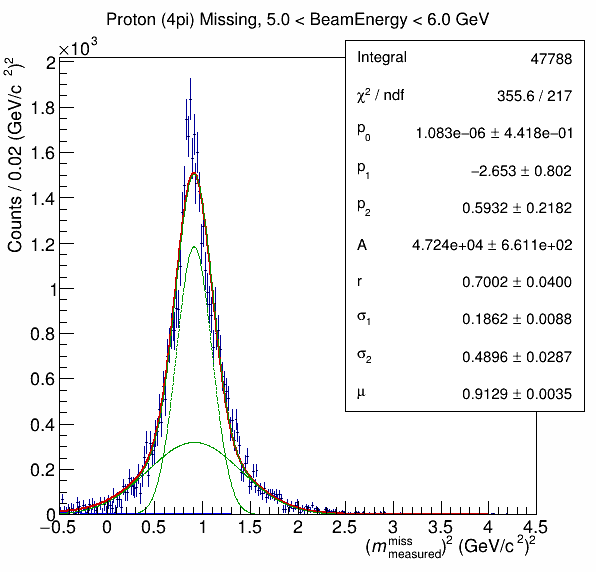

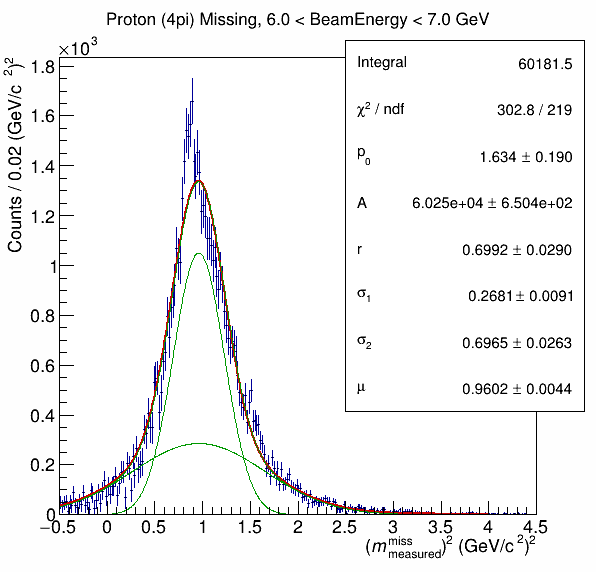

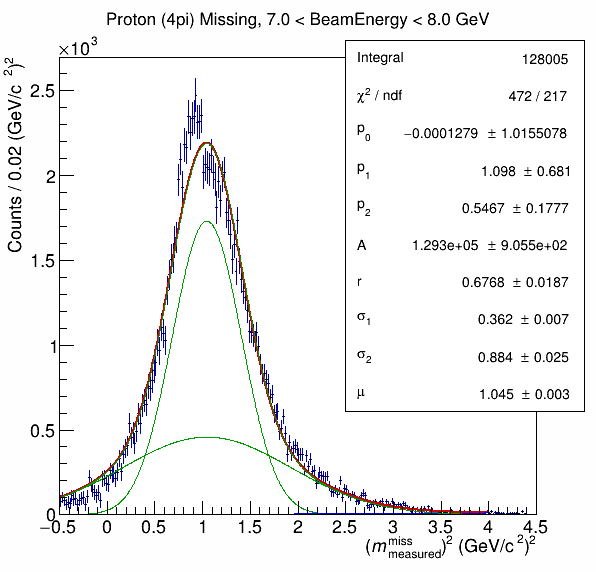

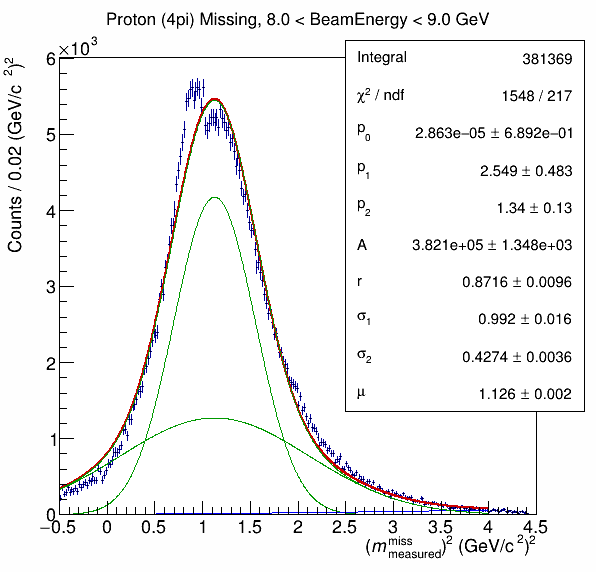

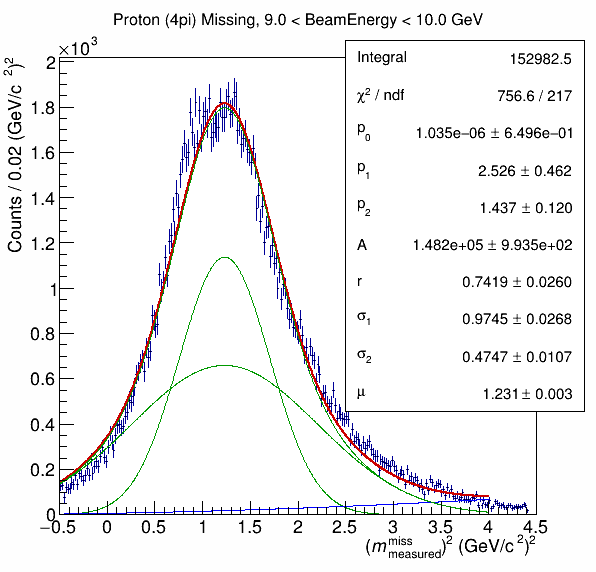

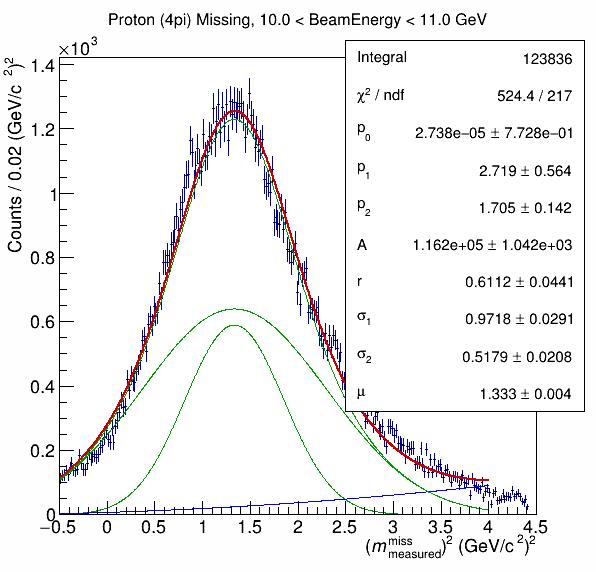

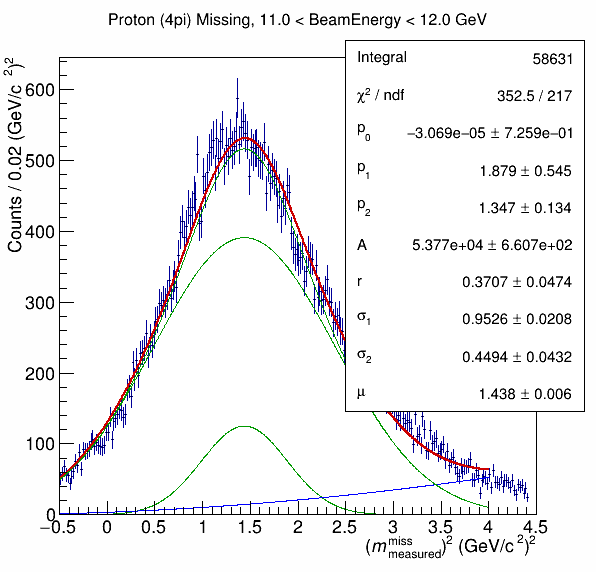

In [16]:
canvsKinBins = {}
for case, MM2Hists in MM2HistsKinBins.items():
  canvsKinBins[case] = {}
  for kinBin, MM2Hist in MM2Hists.items():
    canvsKinBins[case][kinBin] = ROOT.TCanvas(sanitize_filename(f"{selection}_{particle}_{channel}_{dataset}_mm2_{kinBin[0]}_{kinBin[1]}_{kinBin[2]}_fit_{case}{pdfFileNameSuffix}"), "")
    MM2Hist.SetMinimum(0)
    MM2Hist.Draw()
    canvsKinBins[case][kinBin].Update()  # needed otherwise TPaveStats object is not created
    stats = MM2Hist.FindObject("stats")
    stats.SetX1NDC(0.58)
    stats.SetX2NDC(0.98)
    stats.SetY1NDC(0.28)
    stats.SetY2NDC(0.93)
    canvsKinBins[case][kinBin].Draw()
    canvsKinBins[case][kinBin].SaveAs(".pdf")

### Plot fit parameters

Get values of fit parameters

In [17]:
fitParValues = {}  # {case : {parameter name : [ [kinematic bin center, parameter value] ...] ...} ...}
for case in fitResultsKinBins.keys():
  fitParValues[case] = {}
  for kinBin, fitResult in fitResultsKinBins[case].items():
    kinBinCenter = (kinBin[1] + kinBin[2]) / 2
    for parIndex in range(fitResult.NTotalParameters()):
      parName = fitResult.ParName(parIndex)
      parValue = getFitParameter(fitResult, parName)
      if not parName in fitParValues[case]:
        fitParValues[case][parName] = []
      fitParValues[case][parName].append([kinBinCenter, parValue])
    parName  = "#chi^{2}/ndf"
    parValue = ufloat(fitResult.Chi2() / fitResult.Ndf(), 0)
    if not parName in fitParValues[case]:
      fitParValues[case][parName] = []
    fitParValues[case][parName].append([kinBinCenter, parValue])
# print(fitParValues)

Postprocess fit-parameter values

In [18]:
for case in fitParValues.keys():
  for kinBinIndex, r in enumerate(fitParValues[case]["r"]):
    # calculate Gaussian 2 fraction
    ratio = sin(r[1])**2
    # make sure sigma_1 is the narrow Gaussian
    sigma1 = fitParValues[case]["#sigma_{1}"][kinBinIndex][1]
    sigma2 = fitParValues[case]["#sigma_{2}"][kinBinIndex][1]
    if sigma1 > sigma2:
      # print("!!!swap")
      # swap values
      fitParValues[case]["#sigma_{1}"][kinBinIndex][1] = sigma2
      fitParValues[case]["#sigma_{2}"][kinBinIndex][1] = sigma1
      #TODO add case for separate mean values
      ratio = 1 - ratio
    # print(kinBinIndex, ratio)
    fitParValues[case]["r"][kinBinIndex][1] = ratio
# print(fitParValues)

Plot fit-parameter values

Info in <TCanvas::Print>: pdf file /w/halld-scshelf2101/bgrube/ProtonTrackEfficiency/trackingEfficiency/justin_Proton_4pi_bggen_2017_01-ver03_mm2_fitpar_p_{0}_BeamEnergy.pdf has been created
Info in <TCanvas::Print>: pdf file /w/halld-scshelf2101/bgrube/ProtonTrackEfficiency/trackingEfficiency/justin_Proton_4pi_bggen_2017_01-ver03_mm2_fitpar_p_{1}_BeamEnergy.pdf has been created
Info in <TCanvas::Print>: pdf file /w/halld-scshelf2101/bgrube/ProtonTrackEfficiency/trackingEfficiency/justin_Proton_4pi_bggen_2017_01-ver03_mm2_fitpar_p_{2}_BeamEnergy.pdf has been created
Info in <TCanvas::Print>: pdf file ./justin_Proton_4pi_bggen_2017_01-ver03_mm2_fitpar_A_BeamEnergy.pdf has been created
Info in <TCanvas::Print>: pdf file ./justin_Proton_4pi_bggen_2017_01-ver03_mm2_fitpar_r_BeamEnergy.pdf has been created
Info in <TCanvas::Print>: pdf file /w/halld-scshelf2101/bgrube/ProtonTrackEfficiency/trackingEfficiency/justin_Proton_4pi_bggen_2017_01-ver03_mm2_fitpar_#sigma_{1}_BeamEnergy.pdf has been

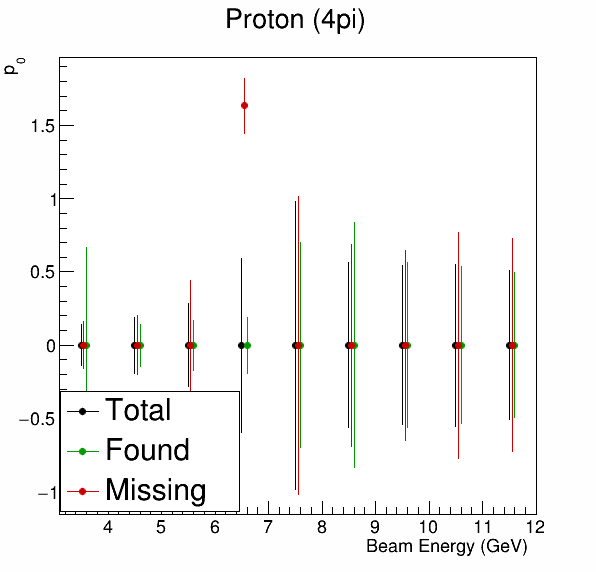

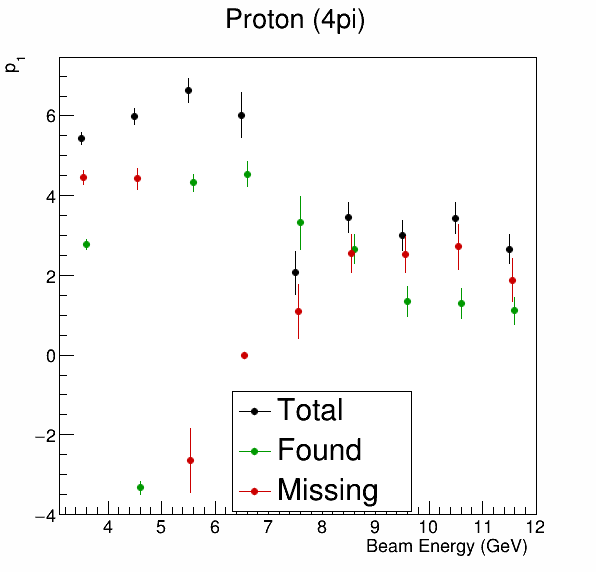

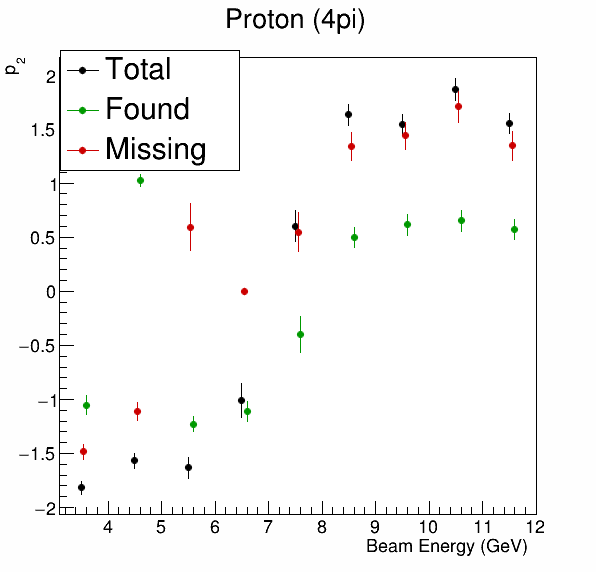

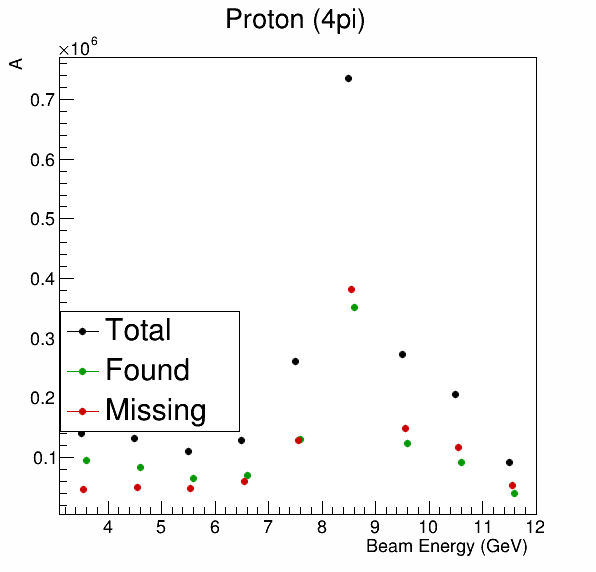

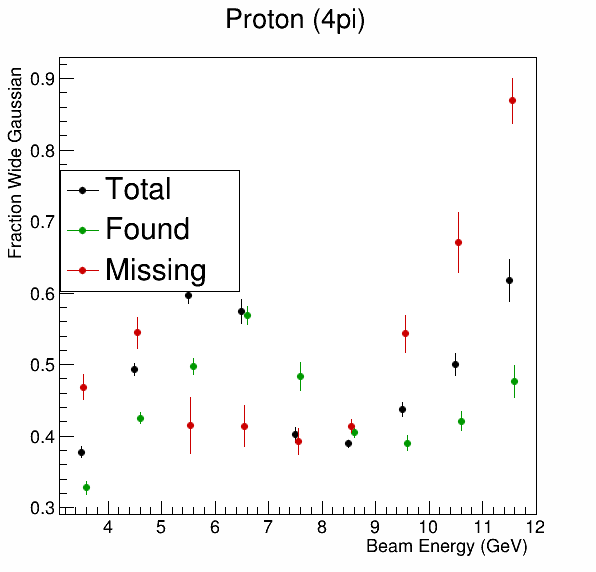

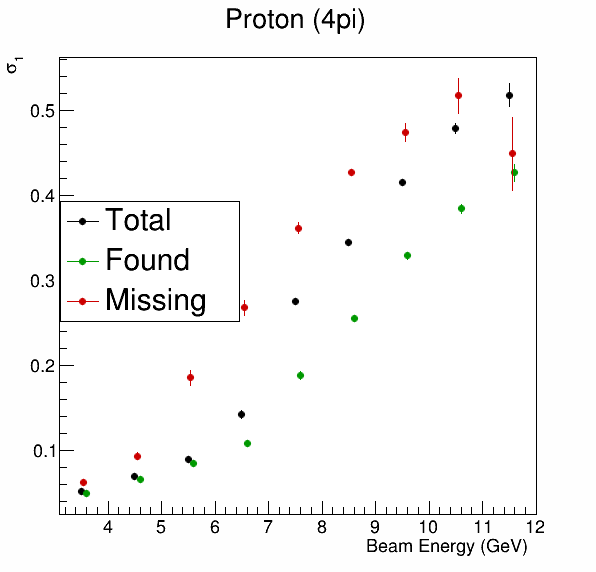

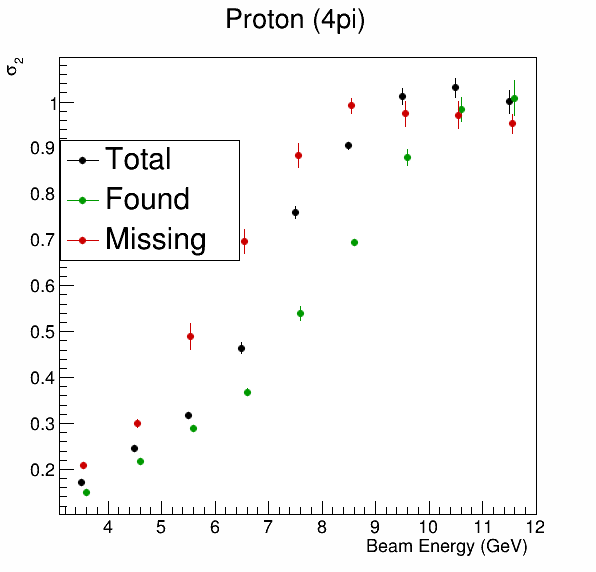

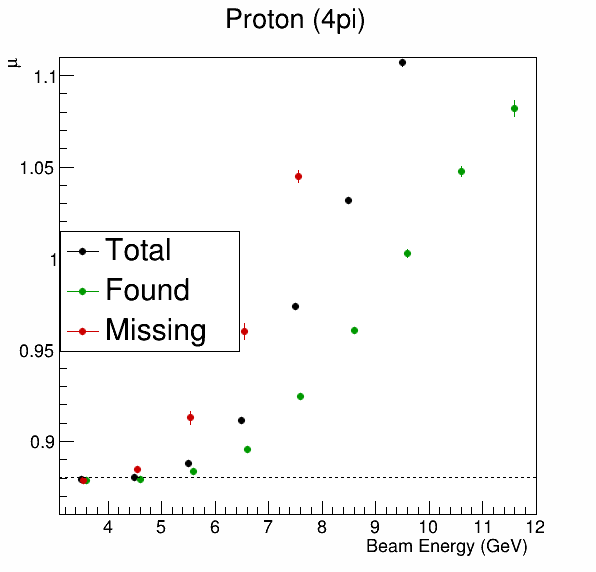

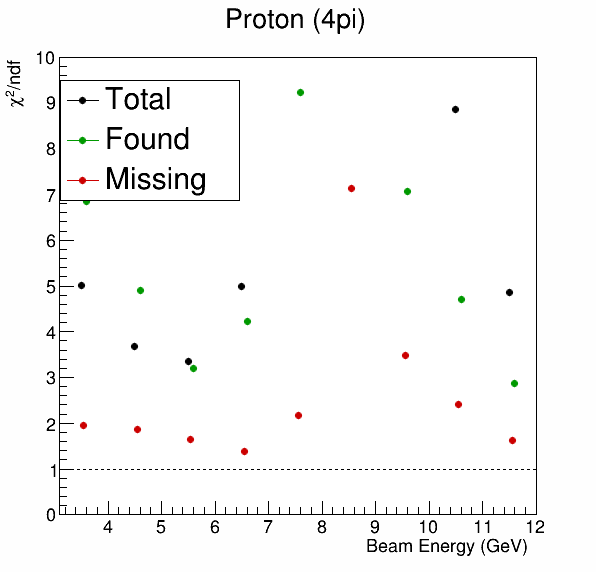

In [19]:
caseColors = {
  "Total"   : ROOT.kBlack,
  "Found"   : ROOT.kGreen + 2,
  "Missing" : ROOT.kRed + 1}
kinVarOffsets = {  #TODO set these according to bin range
  "Total"   : 0,
  "Found"   : 0.1,
  "Missing" : 0.05}
canvsFitPar = []
parValueMultiGraphs = []
parValueGraphs = []
for parName in fitParValues["Total"].keys():
  canvsFitPar.append(ROOT.TCanvas(sanitize_filename(f"{selection}_{particle}_{channel}_{dataset}_mm2_fitpar_{parName}_{kinematicBinning['variable']}{pdfFileNameSuffix}"), ""))
  parValueMultiGraphs.append(ROOT.TMultiGraph())
  parValueGraphs.append({})
  for case in fitParValues.keys():
    parValues = fitParValues[case][parName]
    xVals = array.array('d', [kinVal + kinVarOffsets[case] for kinVal, _ in parValues])
    yVals = array.array('d', [parValue.nominal_value for _, parValue in parValues])
    yErrs = array.array('d', [parValue.std_dev       for _, parValue in parValues])
    parValueGraphs[-1][case] = ROOT.TGraphErrors(len(xVals), xVals, yVals, ROOT.nullptr, yErrs)
    graph = parValueGraphs[-1][case]
    graph.SetTitle(case)
    graph.SetMarkerStyle(ROOT.kFullCircle)
    graph.SetMarkerSize(markerSize)
    graph.SetMarkerColor(caseColors[case])
    graph.SetLineColor(caseColors[case])
    parValueMultiGraphs[-1].Add(graph)
  parValueMultiGraph = parValueMultiGraphs[-1]
  parValueMultiGraph.SetTitle(f"{particle} ({channel})")
  parValueMultiGraph.GetXaxis().SetTitle(f"{kinematicBinning['label']} ({kinematicBinning['unit']})")
  parValueMultiGraph.GetYaxis().SetTitle(parName if parName != "r" else "Fraction Wide Gaussian")
  parValueMultiGraph.Draw("APZ")
  canvsFitPar[-1].BuildLegend()  # crashes for unknown reason
  if parName == "#mu":
    parValueMultiGraph.SetMinimum(0.86)
    parValueMultiGraph.SetMaximum(1.11)
    # indicate nominal value m_p^2 value
    line = ROOT.TLine()
    line.SetLineStyle(ROOT.kDashed)
    protonMassSq = 0.93827208816**2
    line.DrawLine(parValueMultiGraph.GetXaxis().GetXmin(), protonMassSq, parValueMultiGraph.GetXaxis().GetXmax(), protonMassSq)
  if parName == "#chi^{2}/ndf":
    parValueMultiGraph.SetMinimum(0)
    parValueMultiGraph.SetMaximum(10)
    # indicate nominal value
    line = ROOT.TLine()
    line.SetLineStyle(ROOT.kDashed)
    line.DrawLine(parValueMultiGraph.GetXaxis().GetXmin(), 1, parValueMultiGraph.GetXaxis().GetXmax(), 1)
  canvsFitPar[-1].Draw()
  canvsFitPar[-1].SaveAs(".pdf")

### Calculate and plot efficiencies

In [20]:
efficienciesKinBins = {}
for kinBin in fitResultsKinBins["Total"].keys():
  fitResults = {case : fitResultsKinBins[case][kinBin] for case in fitResultsKinBins.keys()}
  efficienciesKinBins[kinBin] = calculateEfficiency(fitResults)
for kinBin, efficiency in efficienciesKinBins.items():
  print(f"Efficiency in kinematic bin {kinBin[1]} < {kinBin[0]} < {kinBin[2]} {kinematicBinning['unit']} = {100 * efficiency}%")

Efficiency in kinematic bin 3.0 < BeamEnergy < 4.0 GeV = 67.37+/-0.20%
Efficiency in kinematic bin 4.0 < BeamEnergy < 5.0 GeV = 62.31+/-0.24%
Efficiency in kinematic bin 5.0 < BeamEnergy < 6.0 GeV = 57.7+/-0.4%
Efficiency in kinematic bin 6.0 < BeamEnergy < 7.0 GeV = 53.91+/-0.31%
Efficiency in kinematic bin 7.0 < BeamEnergy < 8.0 GeV = 50.13+/-0.23%
Efficiency in kinematic bin 8.0 < BeamEnergy < 9.0 GeV = 47.92+/-0.11%
Efficiency in kinematic bin 9.0 < BeamEnergy < 10.0 GeV = 45.41+/-0.20%
Efficiency in kinematic bin 10.0 < BeamEnergy < 11.0 GeV = 43.97+/-0.27%
Efficiency in kinematic bin 11.0 < BeamEnergy < 12.0 GeV = 42.1+/-0.4%


Info in <TCanvas::Print>: pdf file ./justin_Proton_4pi_bggen_2017_01-ver03_mm2_eff_BeamEnergy.pdf has been created


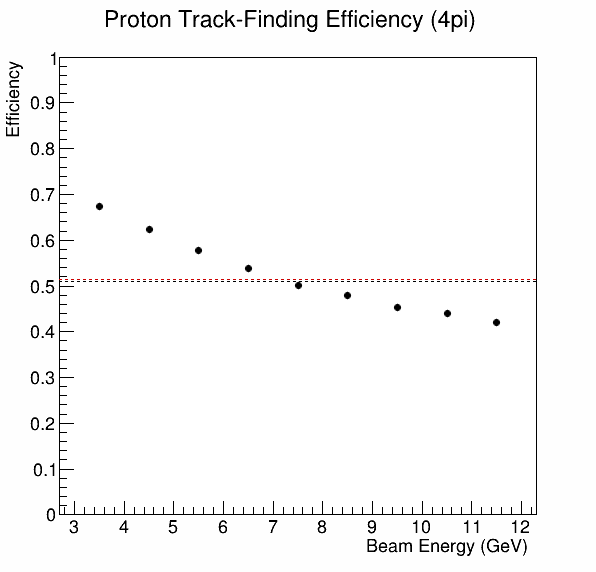

In [21]:

graphVals = [((kinBin[1] + kinBin[2]) / 2, efficiency) for (kinBin, efficiency) in efficienciesKinBins.items()]
xVals = array.array('d', [graphVal[0]               for graphVal in graphVals])
yVals = array.array('d', [graphVal[1].nominal_value for graphVal in graphVals])
yErrs = array.array('d', [graphVal[1].std_dev       for graphVal in graphVals])
# print(xVals, yVals, yErrs)
efficienciesKinBinsGraph = ROOT.TGraphErrors(len(graphVals), xVals, yVals, ROOT.nullptr, yErrs)
efficienciesKinBinsGraph.SetTitle(f"{particle} Track-Finding Efficiency ({channel})")
efficienciesKinBinsGraph.SetMarkerStyle(ROOT.kFullCircle)
efficienciesKinBinsGraph.SetMarkerSize(markerSize)
efficienciesKinBinsGraph.GetXaxis().SetTitle(f"{kinematicBinning['label']} ({kinematicBinning['unit']})")
efficienciesKinBinsGraph.GetYaxis().SetTitle("Efficiency")
efficienciesKinBinsGraph.SetMinimum(0)
efficienciesKinBinsGraph.SetMaximum(1)
canvEff = ROOT.TCanvas(sanitize_filename(f"{selection}_{particle}_{channel}_{dataset}_mm2_eff_{kinematicBinning['variable']}{pdfFileNameSuffix}"), "")
efficienciesKinBinsGraph.Draw("AP")
# indicate value from fit of overall distributions
line = ROOT.TLine()
line.SetLineStyle(ROOT.kDashed)
line.DrawLine(efficienciesKinBinsGraph.GetXaxis().GetXmin(), overallEff.nominal_value, efficienciesKinBinsGraph.GetXaxis().GetXmax(), overallEff.nominal_value)
# indicate weighted average of efficiencies in kinematic bins
meanEff = np.average(yVals, weights = [1 / (yErr**2) for yErr in yErrs])
line.SetLineColor(ROOT.kRed + 1)
line.DrawLine(efficienciesKinBinsGraph.GetXaxis().GetXmin(), meanEff, efficienciesKinBinsGraph.GetXaxis().GetXmax(), meanEff)
canvEff.Draw()
canvEff.SaveAs(".pdf")

# Scratchpad

(TF1 &) Name: func Title: func


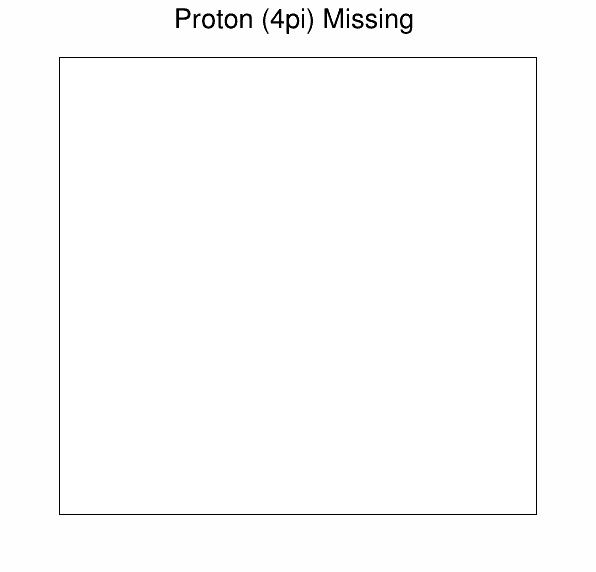

In [22]:
# see https://root-forum.cern.ch/t/syntax-of-a-free-function-or-c-functor-for-tgraph-fitting/22292/3
# and https://root.cern/manual/python/#just-in-time-compilation-of-small-strings
ROOT.gInterpreter.ProcessLine('''
struct MyFunction {
  MyFunction() { }

  double operator() (double* vars, double* pars)
  {
    const double x  = vars[0];
    const double p0 = pars[0];
    const double p1 = pars[1];
    const double p2 = pars[2];

    const double linTerm = p1 + p2 * x;
    return p0 * p0 + linTerm * linTerm;
  }
};
''')
myFunc = ROOT.MyFunction()
func = ROOT.TF1("func", myFunc, -1, 1, 3)
# make function visible in Cling's global scope so it can be used in TFormula
# see https://root-forum.cern.ch/t/advanced-tformula-and-tf1-usage/36643/2
ROOT.gInterpreter.ProcessLine("TF1& func = *((TF1*)gROOT->GetFunction(\"func\"))")
#!!! parameter setting in TFormula expression does not work
fooFunc = ROOT.TF1("fooFunc", "func(x)", -1, 1, 3)
fooFunc.SetParameter(0, -1)
fooFunc.SetParameter(1, -2)
fooFunc.SetParameter(2, -3)
# fooFunc = ROOT.TF1("fooFunc", "func(x, [2..4])", -1, 1, 5)
# fooFunc.SetParameter(0, 10)
# fooFunc.SetParameter(1, -5)
# fooFunc.SetParameter(2, -1)
# fooFunc.SetParameter(3, -2)
# fooFunc.SetParameter(4, -3)
# canv = ROOT.TCanvas("canv", "", 800, 600)
fooFunc.Draw()
canv.Draw()